# Wind Turbine Power Prediction




## Aim of the Study:

**To predict wind turbine power production from the wind speed, wind direction, month of the year and the hour of the day.** 

## Importing Libraries and Spark Configuration

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
!pip install pyspark

     |████████████████████████████████| 311.1 MB 15 kB/s s eta 0:00:01
     |████████████████████████████████| 200 kB 59.7 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.4.2-py2.py3-none-any.whl size=311619856 sha256=d5ce93100a64c0498ab85864a701024aeee83a22fa1e61c0e1586f476266f5f5
  Stored in directory: /root/.cache/pip/wheels/c3/8a/ac/cd39777597318310141c8a783c06f516815a66194f100f96b6
Successfully built pyspark
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

# Configuration of Spark Session
spark = SparkSession.builder.master("local").appName("wind_turbine_project").getOrCreate()
sc = spark.sparkContext
sc

/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


<SparkContext master=local appName=wind_turbine_project>

## Reading the Dataset

In [4]:
# Reading the dataset as Spark DataFrame
spark_df = spark.read.csv('../input/wind-turbine-scada-dataset/T1.csv', header=True, inferSchema=True)

# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print('Show the first 5 rows')
print(spark_df.show(5))
print()
print('What are the variable data types?')
print(spark_df.printSchema())
print()
print('How many observations do we have?')
print(spark_df.count())

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

Wh

In [5]:
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))

print(spark_df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

## Exploratory Data Analysis

In [6]:
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

In [7]:
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68
std,4.23,1368.02,1312.46
min,0.00,0.00,-2.47
25%,4.20,161.33,50.68
50%,7.10,1063.78,825.84
75%,10.30,2964.97,2482.51
max,25.21,3600.00,3618.73


### Difference between the months for average power production 

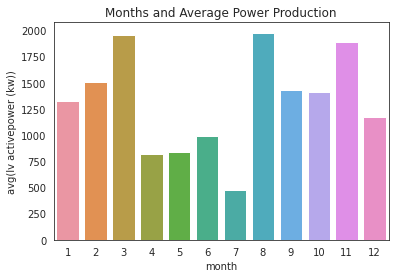

In [8]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

### Difference between the hours for average power production

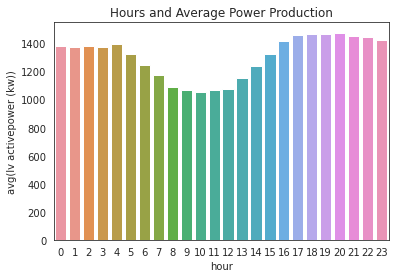

In [9]:
# Average power production by hour
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

### The average power production level for different wind speeds

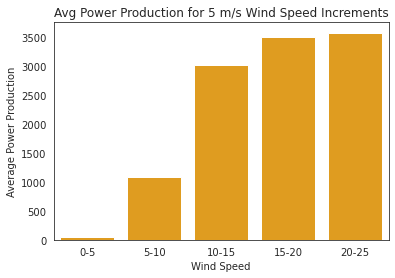

In [10]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i) 
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

**From the graph above we can see the power production reaches near a maximum level after the wind speed reaches 15 m/s.**

### Manufacturer's theoritical power production curve vs the real production

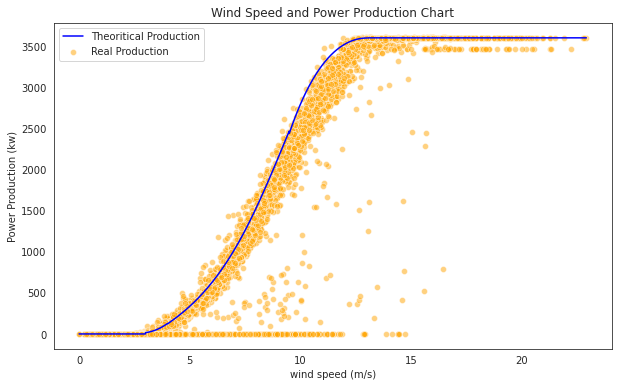

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

**From the graph above, we can see the theoritical power production curve generally fits well with the real production.**



### Wind speed threshold value for zero theorical power

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
2841,2.89,0.00,0.00
3351,2.31,0.00,0.00
138,0.87,0.00,0.00
5588,2.29,0.00,0.00
6713,2.47,0.00,0.00


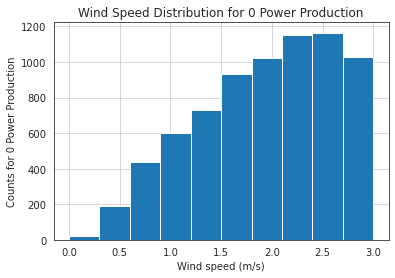

In [12]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

**We can see from above, limit for the theoritical power curve is 3 m/s wind speed. If the wind speed is below 3 m/s model doesn't expect any power production.**

**But there are some observations for 0 power production even the wind speed is more than 3 m/s.**



In [13]:
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
0,03 01 2018 15:40,0.00,3.74,83.99,245.07,1,15
1,03 01 2018 16:40,0.00,3.03,17.18,221.09,1,16
2,03 01 2018 16:50,0.00,3.20,25.43,232.68,1,16
3,03 01 2018 17:00,0.00,3.91,110.98,241.97,1,17
4,04 01 2018 13:50,0.00,3.44,45.74,79.09,1,13


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


**There are 3497 observations where theoritically there should be power production. From the dataset we cannot see the reason, it might be caused by maintenance.**

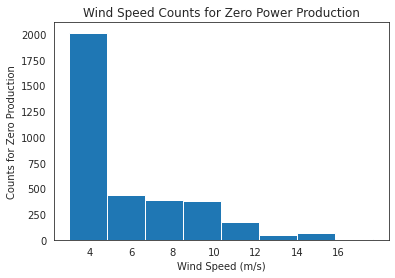

In [14]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

**It looks like theoritically wind speed threshold should be 4 m/s. But there are also other observations with zero power production while the wind speed is higher.**

**The monthly distribution for zero power production:**

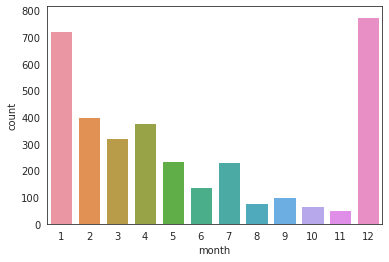

In [15]:
sns.countplot(zero_power['month']);

**It is usually in December and January when the wind turbine doesn't produce production.**

**The 3497 observations are considered as outliers and removed.**

In [16]:
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

In [17]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


## Data Preparation for ML Algorithms

**After analysing and understanding the dataset, we can build a ML regression model to predict wind turbine power production by using the wind speed, wind direction, month of the year and hour of the day.**

**Using ML algorithms with Spark is a bit different from well known Sckitlearn library.**

**We need to feed the model with a dataframe made of variables compressed in vectors called as 'features', and target variable as 'label'. For these convertions I am going to use VectorAssembler method from Pyspark.**

In [18]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



## Train Test Split



In [19]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37571
Test dataset :  9462


## Creating the Initial Model

**Using GBT Regressor.**

In [20]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0| 39.95299286260441|
|             0.0|15.796545533331475|
|288.439788818359| 234.1506249717793|
| 346.68569946289| 358.1089607485242|
|325.626312255859| 358.1089607485242|
|685.547424316406| 673.4829663034355|
|825.766174316406| 756.9075651525064|
|874.722473144531|1082.8391117934295|
|1183.02099609375| 1054.671635950729|
|842.209289550781|1082.8391117934295|
|1182.03503417968|  1197.61177777088|
|1101.72900390625|1225.7792536135805|
|1202.81103515625|  1197.61177777088|
|893.031311035156| 990.9895669067578|
| 2295.8310546875| 2317.687530155214|
|  2796.876953125|2752.3630311414654|
|2947.68408203125| 3041.646721475362|
|3083.24389648437| 3041.646721475362|
|3147.27587890625| 3041.646721475362|
|3330.92700195312| 3281.177831956825|
+----------------+------------------+
only showing top 20 rows



**Model Evaluation.**

In [21]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9789053638222386
MAE      :  85.39253446753875
RMSE     :  190.23361670909472


**R2 score means, real power production's 97% variability can be explained by the ML model.**

**MAE is the mean absolute difference between the real and predicted power production.**

**RMSE is the square root of mean squared difference between the real and predicted values.**

**Even though the R2 is high, we should also check the MAE and RMSE values with the real value's summary statistics.**

**One can tune the hyperparameters to increase the model success. But I this look good enough for me.**

## Comparing Real, Theoritical and Predicted Power Productions

**I am going to use sample_df for comparing the actual, theoritical and the model power productions.**

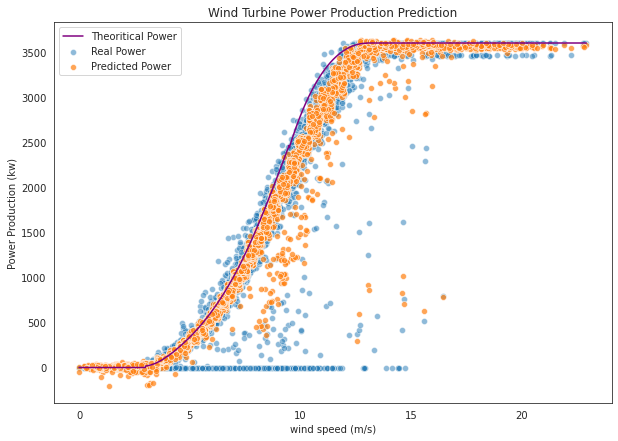

In [22]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

**From the graph above, the model fits better to the real power productions, than the theoritical power production curve.**